In [46]:
#Utilities
import numpy as np 

def rademacher_variables(vec_size):
    if vec_size % 2 != 0:
        return("Error, vector size should be even.")
    s = np.random.binomial(1,0.5, vec_size)
    a = sum(s)
    while a.all() !=0:
        s = np.random.binomial(1,0.5, vec_size)
        s[s < 1] = -1
        a = sum(s)
    return(s)
      
def rademacher_bound(array_x, delta, train_error, array_Rademacher):
    c =3*(np.sqrt(np.log(2/delta))/(2*(array_x)))
    bound = np.add(train_error, array_Rademacher)
    bound = np.add(bound,c)
    return(bound)

def vc_dimension_regression(array_x, array_Rademacher):
    c = array_x/(2*np.log(array_x))
    VC = (array_Rademacher**2)*c
    return(VC)

def VC_bound(array_x, train_error, array_VCdim, delta):
    a = array_VCdim/array_x #VC/#samples
    b = np.log(array_x/array_VCdim)
    #b = np.log(array_x)/(2*array_x) #log(#samples)/2*(#samples)
    #b = np.where(b > 0, b, 10**(-8))
    c = np.log(delta/4)
    VCbound = train_error/abs((1-0.1*np.sqrt(a+a*b-c)))
    #VCbound[i] = train_error[i]/(1- np.sqrt(a[i]-(a[i]*np.log(a[i]))+b[i])) #getting nan when function 
    return(VCbound)

In [47]:
#Loading data and handling missing values

df_automobile = pd.read_csv("Automobile_data.csv")

df_temp = df_automobile[df_automobile['price']!='?']
normalised_mean = df_temp['price'].astype(int).mean()
df_automobile['price'] = df_automobile['price'].replace('?',normalised_mean).astype(int)

df_temp = df_automobile[df_automobile['horsepower']!='?']
normalised_mean = df_temp['horsepower'].astype(int).mean()
df_automobile['horsepower'] = df_automobile['horsepower'].replace('?',normalised_mean).astype(int)

df_temp = df_automobile[df_automobile['peak-rpm']!='?']
normalised_mean = df_temp['peak-rpm'].astype(int).mean()
df_automobile['peak-rpm'] = df_automobile['peak-rpm'].replace('?',normalised_mean).astype(int)


df_automobile.describe()

,symboling,Brand,num-of-doors,wheel-base,length,width,h8,curb-w8,num-of-cylinders,engine-size,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,13.195122,3.112195,98.756585,174.049268,65.907805,53.724878,2555.565854,4.380488,126.907317,10.142537,104.253659,5125.365854,25.219512,30.751220,13207.126829
std,1.245307,6.274831,0.996119,6.021776,12.337289,2.145204,2.443522,520.680204,1.080854,41.642693,3.972040,39.519219,476.979095,6.542142,6.886443,7868.768212
min,-2.000000,1.000000,2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,2.000000,61.000000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,9.000000,2.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,4.000000,97.000000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,1.000000,13.000000,4.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,4.000000,120.000000,9.000000,95.000000,5200.000000,24.000000,30.000000,10595.000000
75%,2.000000,20.000000,4.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,4.000000,141.000000,9.400000,116.000000,5500.000000,30.000000,34.000000,16500.000000
max,3.000000,22.000000,4.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,12.000000,326.000000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [48]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from random import sample

n = range(6,150, 10)
n_2 = range(0,100,1)

test_error = []
train_error = []
temp_test = []
temp_train = []
temp_L = []
Rad = []

#Test set
df_x = df_automobile
df_x = df_x[['engine-size', 'horsepower', 'peak-rpm', 'Brand', 'num-of-doors']]
df_y = df_automobile['price']
X, X_test, Y, Y_test = train_test_split(df_x, df_y, test_size = 0.25)


for counter,value in enumerate(n): 
    for j in n_2:
        #step 1 - train set
        idx = sample(range(0,len(X)), value)
        X_train = X.iloc[idx]
        Y_train = Y.iloc[idx]
     
        Y_pred_train = np.empty_like(Y_train)
        Y_pred_test = np.empty_like(Y_test)
    
        #rademacher sigma
        s = rademacher_variables(len(Y_train))

        #Step 2: model fitting
        #initialisation of linear regression model
        m = LinearRegression()

        #inserting train data into model for training
        m.fit(X_train,Y_train)

        #predicting values for test data
        Y_pred_test = m.predict(X_test)
        Y_pred_train = m.predict(X_train)

        #computing RMSE
        error_test= np.sqrt(mean_squared_error(Y_test, Y_pred_test))
        temp_test.append(error_test)

        error_train= np.sqrt(mean_squared_error(Y_train, Y_pred_train))
        temp_train.append(error_train)

         #Rademacher constant      
        temp_L.append(float(2*(np.dot(s, np.sqrt((Y_train-Y_pred_train)**2))/len(Y_train))))
    
    test_error.append(sum(temp_test)/len(temp_test))
    train_error.append(sum(temp_train)/len(temp_train))
    Rad.append((max(temp_L)))
    temp_test.clear()
    temp_train.clear()
    temp_L.clear()

#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Rad)
radBound = rademacher_bound(np.array(n), 0.1, np.array(train_error), np.array(Rad))
print("Rademacher Bound")
print(radBound)
VCdim = vc_dimension_regression(np.array(n), np.array(Rad))
print("VC Dimension")
print(VCdim)
# VCBound = VC_bound(np.array(n), np.array(train_error), VCdim, 0.1)
# print("VC Bound")
# print(VCBound)

Rademacher Constant
[437.9826698816517, 2241.3912719085088, 2611.8242052244236, 1434.665678044754, 1851.8295676467615, 1677.3754025074109, 1469.7900134262582, 1291.7005717512484, 1522.6728273696428, 1646.1074191591024, 1002.3376081520288, 1102.5926567366105, 1287.4013276535652, 1370.390876157513, 1337.9360467152692]
Rademacher Bound
[ 528.25823796 4928.60108457 5909.90257085 4867.39565711 5401.19128074
 5339.47154249 5209.79085927 5026.70590861 5291.5118738  5424.26983616
 4863.62276793 4950.13651131 5188.42698698 5243.15225601 5252.23608535]
VC Dimension
[  321185.10728335 14495723.20190132 27218694.34869575 10338659.17160042
 20600851.58860159 19571077.70919899 17015561.65061199 14640161.13820186
 22381932.20135256 28495666.20330159 11418199.10228352 14833254.45258457
 21590209.01819192 25994506.31180621 26221034.09669034]


ValueError: x and y must have same first dimension, but have shapes (15,) and (8,)

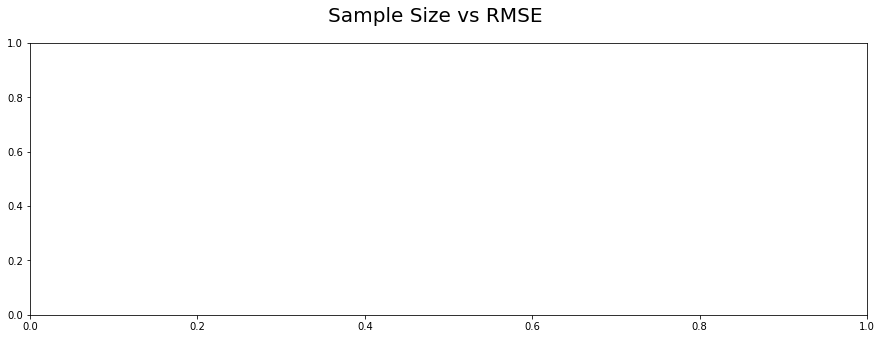

In [45]:
#Step 3: Evaluation

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,5))
fig.suptitle('Sample Size vs RMSE',fontsize=20)
ax.plot(n,train_error,color='blue', label = 'Train')
ax.plot(n,test_error,color = 'green', label = 'Test')
ax.plot(n,radBound.reshape(-1,1), color = 'red', label = 'Rad')
#ax.plot(n, VCBound.reshape(-1,1), color = 'purple', label = 'VC')
ax.legend(loc='upper right')
plt.show()



In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from random import sample

samples = 100
n_2 = range(0,100,1)
pw = range(1,9,1)

test_error = []
train_error = []
temp_test = []
temp_train = []
temp_L = []
Rad = []
h = 0

#Test set
#Test set
df_x = df_automobile
df_x = df_x[['engine-size', 'horsepower', 'peak-rpm', 'Brand', 'num-of-doors']]
df_y = df_automobile['price']
X, X_test, Y, Y_test = train_test_split(df_x, df_y, test_size = 0.25)


for i in pw:
    print("polyonomial: " + str(i))
    for j in n_2:
        #step 1 - train set
        idx = sample(range(0,len(X)), samples)
        X_train = X.iloc[idx]
        Y_train = Y.iloc[idx]
     
        Y_pred_train = np.empty_like(Y_train)
        Y_pred_test = np.empty_like(Y_test)
        
        #calculating polinomial features from 1 to 10 degree
        poly = PolynomialFeatures(degree = h+1) 
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.fit_transform(X_test)
    
        #rademacher sigma
        s = rademacher_variables(len(Y_train))

        #Step 2: model fitting
        #initialisation of linear regression/insert data for training/prediction
        m = LinearRegression()

        #inserting train data in model for training
        m.fit(X_poly_train,Y_train)

        #predicting values for test data
        Y_pred_test = m.predict(X_poly_test)
        Y_pred_train = m.predict(X_poly_train)

        #computing RMSE
        error_test= np.sqrt(mean_squared_error(Y_test, Y_pred_test))
        temp_test.append(error_test)

        error_train= np.sqrt(mean_squared_error(Y_train, Y_pred_train))
        temp_train.append(error_train)

         #Rademacher constant      
        temp_L.append(float(2*(np.dot(s, np.sqrt((Y_train-Y_pred_train)**2))/len(Y_train))))
    
    test_error.append(sum(temp_test)/len(temp_test))
    train_error.append(sum(temp_train)/len(temp_train))
    Rad.append((max(temp_L)))
    temp_test.clear()
    temp_train.clear()
    temp_L.clear()
    h += 1

#Calculating Rademacher and VC Bounds
print("Test Error")
print(test_error)
print("Rademacher Constant")
print(Rad)
radBound = rademacher_bound((np.array(samples))*np.ones(len(pw)), 0.1, np.array(train_error), np.array(Rad))
print("Rademacher Bound")
print(radBound)
VCdim = vc_dimension_regression((np.array(samples))*np.ones(len(pw)), np.array(Rad))
print("VC Dimension")
print(VCdim)
VCBound = VC_bound((np.array(samples))*np.ones(len(pw)), np.array(train_error), VCdim, 0.1)
print("VC Bound")
print(VCBound)

[4261.97019844779, 5015.643424458998, 27974.058463501035, 1547985.730375519, 3052334.8952430235, 4097913.0556947202, 3476586.7045724685, 4209375.313273463]


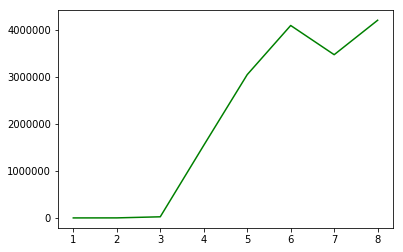

In [42]:
#Step 3: Evaluation

print(test_error)
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,5))
# fig.suptitle('Model Capacity vs RMSE',fontsize=20)
#ax.plot(pw,train_error,color='blue', label = 'Train')
plt.plot(pw,test_error,color = 'green', label = 'Test')
#ax.plot(pw,radBound.reshape(-1,1), color = 'red', label = 'Rad')
#ax.plot(pw, VCBound.reshape(-1,1), color = 'purple', label = 'VC')
# ax.legend(loc='upper right')
# plt.show()

